# Install or upgrade libraries

It might be that you are running with the latest libraries and that they all work together fine. 

Running the following cell takes a minute or so but ensures that you have a consistent set of python tools. 

In [1]:
import sys
print(f"{sys.version = }\n")


sys.version = '3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:23:25) [GCC 13.3.0]'



In [2]:
# If there are issues with fsspect-xrootd not being found, run this outside of Jupyter-notebook and restart
# !pip install --upgrade fsspec-xrootd

In [3]:
#'''
!pip install --upgrade pip

!pip install futures 

!pip install --user --upgrade coffea

!pip install --upgrade awkward
!pip install --upgrade uproot

!pip install --upgrade fsspec-xrootd

!pip install vector

!pip install --upgrade pandas


!pip install --upgrade matplotlib
#'''

We've also prepared some helper code that makes it easier to work with the data in this lesson.

You can see the code [here](https://github.com/cms-opendata-workshop/workshop2024-lesson-event-selection/blob/main/instructors/dpoa_workshop_utilities.py) but we will explain the functions and data objects in this notebook. 

Let's download it first. 

In [4]:
#!wget https://raw.githubusercontent.com/cms-opendata-workshop/workshop2024-lesson-event-selection/main/instructors/dpoa_workshop_utilities.py

## Imports

Import all the libraries we will need and check their versions, in case you run into issues. 

In [5]:
%load_ext autoreload
%autoreload 2

# The classics
import numpy as np
import matplotlib.pylab as plt
import matplotlib # To get the version

import pandas as pd

# The newcomers
import awkward as ak
import uproot

import vector
vector.register_awkward()

import requests
import os

import time

import json

import dpoa_workshop_utilities
from dpoa_workshop_utilities import nanoaod_filenames
from dpoa_workshop_utilities import get_files_for_dataset
from dpoa_workshop_utilities import pretty_print
from dpoa_workshop_utilities import build_lumi_mask

import sys

In [6]:
print("Versions --------\n")
print(f"{sys.version = }\n")
print(f"{ak.__version__ = }\n")
print(f"{uproot.__version__ = }\n")
print(f"{np.__version__ = }\n")
print(f"{matplotlib.__version__ = }\n")
print(f"{vector.__version__ = }\n")
print(f"{pd.__version__ = }\n")

Versions --------

sys.version = '3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:23:25) [GCC 13.3.0]'

ak.__version__ = '2.8.3'

uproot.__version__ = '5.6.2'

np.__version__ = '1.26.4'

matplotlib.__version__ = '3.10.3'

vector.__version__ = '1.6.2'

pd.__version__ = '2.3.0'



# Opening a file

Let's open and explore a sample file. 

We'll be getting the data from [here](https://opendata.cern.ch/record/67993).

This is some Monte Carlo that contains simulations of a top-antitop pair being created in a proton-proton collision at CMS. 

One top decays leptonically and the other decays hadronically. 

**Do you know what leptonically and hadronically mean? If not, do a bit of research.**

When you go to open the file, it might take 10-30 seconds at this step if you are working with the larger file.

In [7]:
# # For testing
# # Big file
# #filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'

# # Smaller file, better for prototyping your code as things will run faster
# filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root'

# print(f"Opening...{filename}")
# f = uproot.open(filename)

# events = f['Events']

# nevents = events.num_entries

# print(f"{nevents = }")

In [8]:
def load_file(size):
    '''
    size = "big" or "small"
    '''
    if size == "big": 
        # Big file
        filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'
    elif size == "small":
        # Smaller file, better for prototyping your code as things will run faster
        filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root'

    print(f"Opening...{filename}")
    f = uproot.open(filename)

    events = f['Events']

    nevents = events.num_entries

    print(f"{nevents = }")
    return events

In [9]:
events=load_file("small")

Opening...root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root
nevents = 168000


The `events` object is a `TTree` implementation in python and behaves like a dictionary. This means 
we can get all the keys if we want. 

In [10]:
# Uncomment the following line to print all the keys

#print(events.keys())

Again, we have provided you with a helper function called `pretty_print` that will print subsets of the keys, based on strings
that you require or ignore. 

It will also format that output based on how many characters you want in a column (you are limited to 80 characters per line). 

Here is some example usage. 

In [11]:
# Pretty print all the keys with the default format
#pretty_print(events.keys())

# Pretty print keys with 30 characters per column, for keys that contain `FatJet`
#pretty_print(events.keys(), fmt='30s', require='FatJet')

# Pretty print keys with 40 characters per column, for keys that contain `Muon` and `Iso` but ignore ones with `HLT`
#pretty_print(events.keys(), fmt='40s', require=['Muon', 'Iso'], ignore='HLT')

# Pretty print keys with 40 characters per column, for keys that contain `HLT` and `TkMu50`
#pretty_print(events.keys(), fmt='40s', require=['HLT', 'TkMu50'])

# Pretty print keys with 40 characters per column, for keys that contain `HLT`
#pretty_print(events.keys(), fmt='40s', require='HLT')

# Pretty print keys with 40 characters per column, for keys that contain `Jet_` but ignore ones with `Fat`
pretty_print(events.keys(), fmt='40s', require='Jet_', ignore='Fat')

# Pretty print keys with 40 characters per column, for keys that contain `PuppiMET` but ignore ones with `Raw`
#pretty_print(events.keys(), fmt='40s', require='PuppiMET', ignore='Raw')

CorrT1METJet_area                        CorrT1METJet_eta                         
CorrT1METJet_muonSubtrFactor             CorrT1METJet_phi                         
CorrT1METJet_rawPt                       GenJet_eta                               
GenJet_mass                              GenJet_phi                               
GenJet_pt                                Jet_area                                 
Jet_btagCSVV2                            Jet_btagDeepB                            
Jet_btagDeepCvB                          Jet_btagDeepCvL                          
Jet_btagDeepFlavB                        Jet_btagDeepFlavCvB                      
Jet_btagDeepFlavCvL                      Jet_btagDeepFlavQG                       
Jet_chEmEF                               Jet_chFPV0EF                             
Jet_chHEF                                Jet_eta                                  
Jet_hfsigmaEtaEta                        Jet_hfsigmaPhiPhi                        
Jet_

## Extract some data

We're going to pull out subsets of the data in order to do our analysis. 

As a reminder, you can find a list of the variable names in each dataset on the CERN Open Data Portal page for that dataset, for example, [here](https://opendata.cern.ch/eos/opendata/cms/dataset-semantics/NanoAODSIM/75156/ZprimeToTT_M2000_W20_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8_doc.html).

We're going to work with the following sets of variables
* `FatJet` for jets that are merges
* `Jet` for non-merged jets
* `Muon` for muons
* `PuppiMET` which is missing energy in the transverse plane (MET) for pileup per particle identification (Puppi)

Running this cell might take a little bit if you are running over the bigger file. However, once you pull out the values, later calculations are much faster. 

In [12]:
# Jets ---------------------------------------------------
# B-tagging variable
jet_btagB = events['Jet_btagDeepB'].array()
jet_btagFlavB = events ['Jet_btagDeepFlavB'].array()

# Measure of quality of measurement of jet
jet_jetid = events['Jet_jetId'].array()

# 4-momentum in pt, eta, phi, mass 
jet_pt = events['Jet_pt'].array()
jet_eta = events['Jet_eta'].array()
jet_phi = events['Jet_phi'].array()
jet_mass = events['Jet_mass'].array()


# Muons ---------------------------------------------------
# Muon isolation
muon_iso = events['Muon_miniIsoId'].array()

# Measure of quality of how well the muon is reconstructed
muon_tightId = events['Muon_tightId'].array()

# 4-momentum in pt, eta, phi, mass 
muon_pt = events['Muon_pt'].array()
muon_eta = events['Muon_eta'].array()
muon_phi = events['Muon_phi'].array()
muon_mass = events['Muon_mass'].array()


# MET ------------------------------------------------------
# 3-momentum in pt, eta, phi, mass 
met_pt = events['PuppiMET_pt'].array()
met_eta = 0*events['PuppiMET_pt'].array()  # Fix this to be 0
met_phi = events['PuppiMET_phi'].array() 

#FatJets ----------------------------------------------------
# 4-momentum in pt, eta, phi, mass 
fatjet_pt = events['FatJet_pt'].array()
fatjet_eta = events['FatJet_eta'].array()
fatjet_phi = events['FatJet_phi'].array()
fatjet_mass = events['FatJet_mass'].array()


# What comes next?  

## Basic Plots

- Simple Muon Cuts (pt > cut)
- Simpe Jet Cuts (pt > cut)
- The B-tag cut (DeepB > tight, medium, loose)

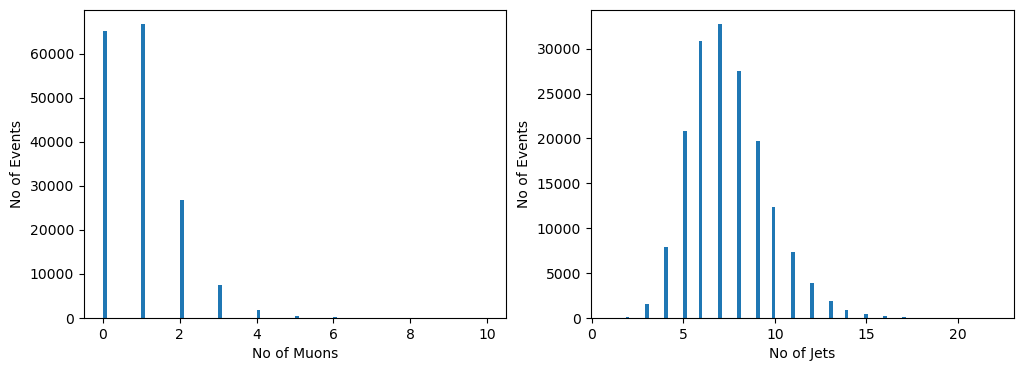

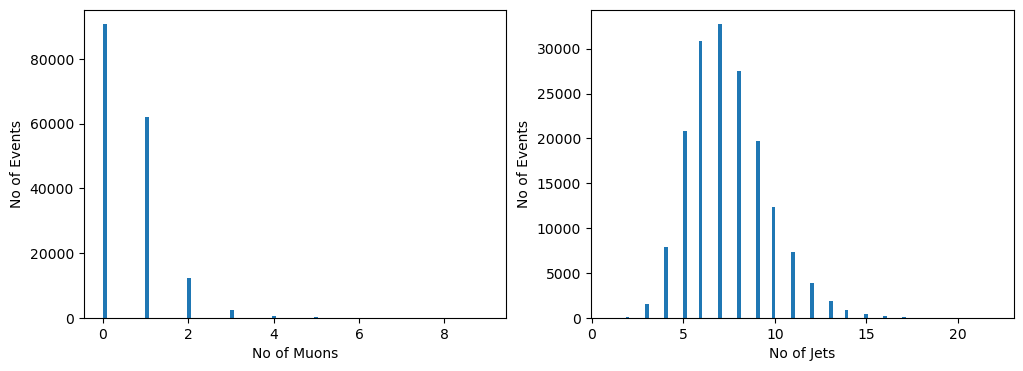

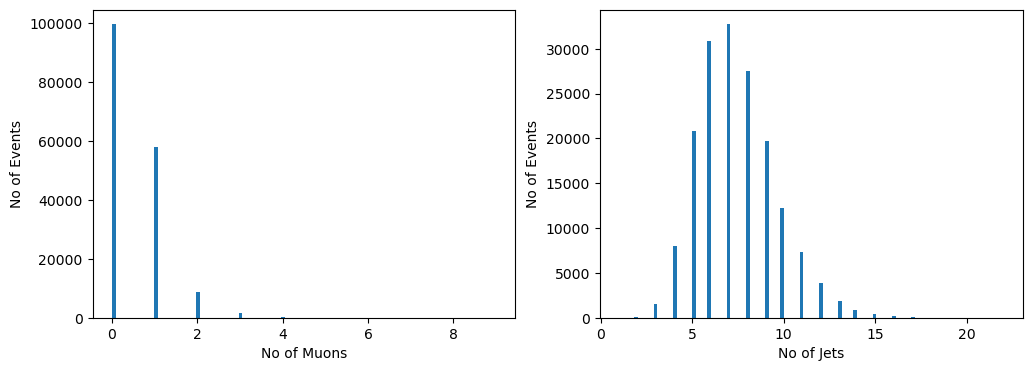

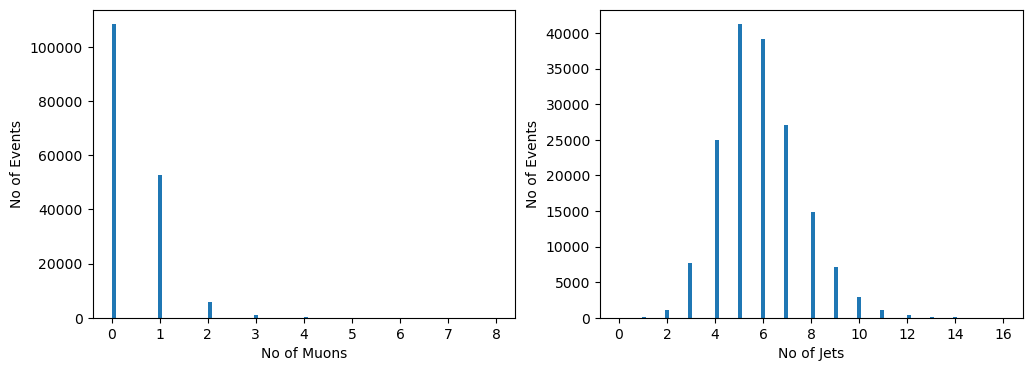

In [13]:
#Simple Muon and Jet cuts 
muon_cut = muon_pt > 20 
jet_cut = jet_pt > 20 

cuts = [0, 10, 15, 20]
for cut in cuts: 
    muon_cut = muon_pt > cut 
    jet_cut = jet_pt > cut
    
    muon_pt_cut = muon_pt[muon_cut]
    jet_pt_cut = jet_pt[jet_cut]

    nmuon = ak.num(muon_pt_cut)
    njet = ak.num(jet_pt_cut)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(nmuon, bins=100);
    plt.xlabel("No of Muons")
    plt.ylabel("No of Events")
    plt.subplot(1,2,2)
    plt.hist(njet,bins=100);
    plt.xlabel("No of Jets")
    plt.ylabel("No of Events")

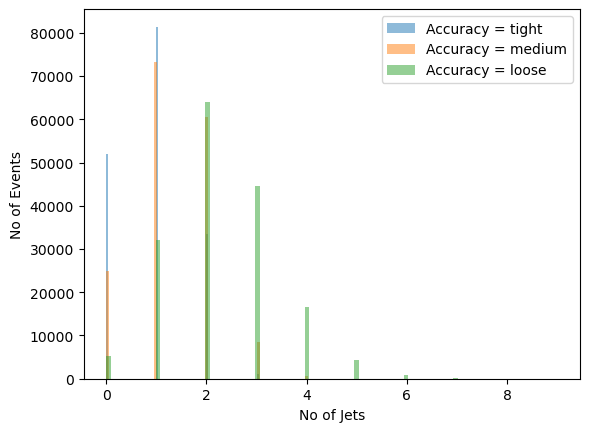

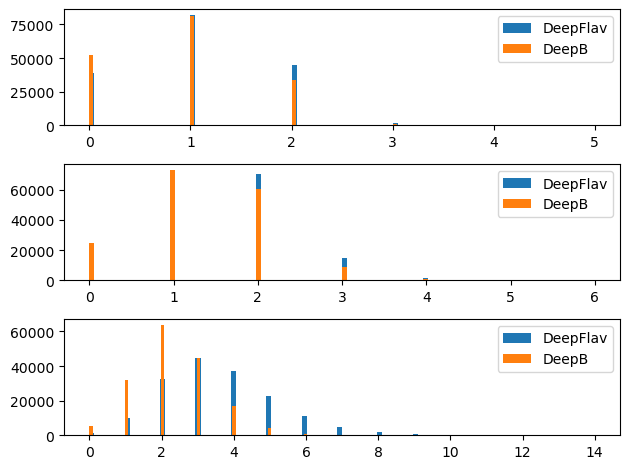

In [14]:
#btag_cuts
'''Values: 
Loose (10% misidentification rate): Jet_btagDeepB > 0.1918 , Jet_btagDeepFlavB > 0.0480
Medium (1% misidentification rate): Jet_btagDeepB > 0.5847, Jet_btagDeepFlavB > 0.2489
Tight (0.1% misidentification rate): Jet_btagDeepB > 0.8767, Jet_btagDeepFlavB > 0.6377
'''
def give_btag_cuts(choice, accuracy):
    '''
    choice = "DeepB" or "DeepFlav" 
    accuracy = "loose" "medium" or "tight" 

    Loose:  Jet_btagDeepB > 0.1918 , Jet_btagDeepFlavB > 0.0480
    Medium: Jet_btagDeepB > 0.5847, Jet_btagDeepFlavB > 0.2489
    Tight: Jet_btagDeepB > 0.8767, Jet_btagDeepFlavB > 0.6377
    '''
    if (choice == "DeepB") & (accuracy == "tight") : return jet_btagB > 0.8767
    if (choice == "DeepB") & (accuracy == "medium"): return jet_btagB > 0.5847
    if (choice == "DeepB") & (accuracy == "loose"): return jet_btagB > 0.1918

    if choice == "DeepFlav":
        if accuracy == "tight": return jet_btagFlavB > 0.6377
        if accuracy == "medium": return jet_btagFlavB > 0.2489
        if accuracy == "loose": return jet_btagFlavB > 0.0480

jet_btag_tight = jet_pt[give_btag_cuts("DeepB","tight")]
jet_btag_medium = jet_pt[give_btag_cuts("DeepB","medium")]
jet_btag_loose = jet_pt[give_btag_cuts("DeepB","loose")]

njet_btag_tight = ak.num(jet_btag_tight)
njet_btag_medium = ak.num(jet_btag_medium)
njet_btag_loose = ak.num(jet_btag_loose)

#Comparision of btagging loose, medium and tight
edgecolors = ['red', 'orange' , 'yellow']
all_njets = [njet_btag_tight, njet_btag_medium, njet_btag_loose]
names = ["tight", "medium", "loose"]
for all, name in zip(all_njets,names): 
    plt.hist(all, bins = 100, alpha = 0.5, label = f"Accuracy = {name}")
    plt.legend()
plt.xlabel("No of Jets")
plt.ylabel("No of Events")
plt.show()

#Comparison of the two different btagging 
jet_btagF_tight = jet_pt[give_btag_cuts("DeepFlav","tight")]
jet_btagF_medium = jet_pt[give_btag_cuts("DeepFlav","medium")]
jet_btagF_loose = jet_pt[give_btag_cuts("DeepFlav","loose")]

njet_btagF_tight = ak.num(jet_btagF_tight)
njet_btagF_medium = ak.num(jet_btagF_medium)
njet_btagF_loose = ak.num(jet_btagF_loose)

plt.subplot(3, 1, 1)
plt.hist(njet_btagF_tight, bins = 100,label= "DeepFlav");
plt.hist(njet_btag_tight, bins=100, label = "DeepB");
plt.legend()

plt.subplot(3,1,2)
plt.hist(njet_btagF_medium, bins = 100, label = "DeepFlav");
plt.hist(njet_btag_medium, bins=100, label = "DeepB");
plt.legend()

plt.subplot(3,1,3)
plt.hist(njet_btagF_loose, bins = 100, label = "DeepFlav");
plt.hist(njet_btag_loose, bins=100, label = "DeepB");
plt.legend()

plt.tight_layout()

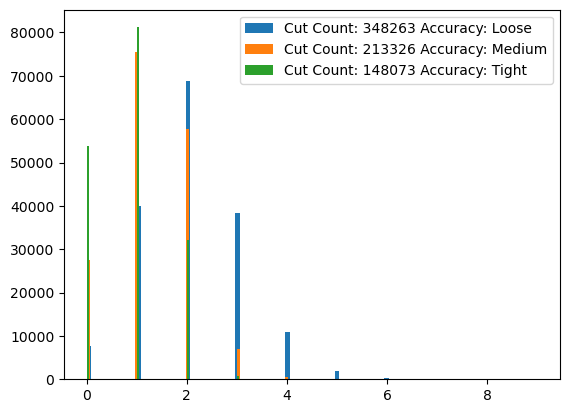

In [15]:
#Mixing b_tag and jet_cuts
jet_cut = jet_pt > cut
jet_pt_cut = jet_pt[jet_cut]
jet_pt_btag_cut1 = jet_pt[give_btag_cuts("DeepB","loose")[jet_cut]]
jet_pt_btag_cut2 = jet_pt[give_btag_cuts("DeepB","medium")[jet_cut]]
jet_pt_btag_cut3 = jet_pt[give_btag_cuts("DeepB","tight")[jet_cut]]
njet_pt_btag_cut1 = ak.num(jet_pt_btag_cut1);
njet_pt_btag_cut2 = ak.num(jet_pt_btag_cut2);
njet_pt_btag_cut3 = ak.num(jet_pt_btag_cut3);
plt.hist(njet_pt_btag_cut1, bins = 100, label = f"Cut Count: {ak.sum(njet_pt_btag_cut1)} Accuracy: Loose");
plt.hist(njet_pt_btag_cut2, bins = 100, label = f"Cut Count: {ak.sum(njet_pt_btag_cut2)} Accuracy: Medium");
plt.hist(njet_pt_btag_cut3, bins = 100, label = f"Cut Count: {ak.sum(njet_pt_btag_cut3)} Accuracy: Tight");
plt.legend()

In [16]:
jet_DeepB=events["Jet_btagDeepB"].array()

In [17]:
#Finding the invariant mass 
fatjets = ak.zip(
    {"pt": fatjet_pt, 
     "eta": fatjet_eta, 
     "phi": fatjet_phi, 
     "mass": fatjet_mass},
    with_name="Momentum4D",
)

muons = ak.zip(
    {"pt": muon_pt, 
     "eta": muon_eta, 
     "phi": muon_phi, 
     "mass": muon_mass},
    with_name="Momentum4D",
)

jets = ak.zip(
    {"pt": jet_pt, 
     "eta": jet_eta, 
     "phi": jet_phi, 
     "mass": jet_mass,
     "DeepB": jet_DeepB },
    with_name="Momentum4D",
)

met = ak.zip(
    {"pt": met_pt, 
     "eta": met_eta, 
     "phi": met_phi, 
     "mass": 0}, # We assume this is a neutrino with 0 mass
    with_name="Momentum4D",
)


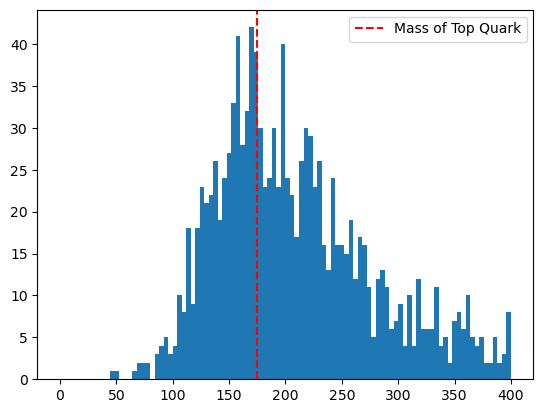

In [18]:
# Cuts

#Muons and Jet Cuts 
muon_cut = (muons.pt > 20) & (np.abs(muons.eta) < 2.1)
jet_cut = (jets.pt>20) & (np.abs(jets.eta) < 2.4)

muons_cut = muons[muon_cut]
jets_cut = jets[jet_cut]

n_muon = ak.num(muons_cut)
n_jets = ak.num(jets_cut)
n_bjets = ak.sum(jets.DeepB > 0.8767, axis = 1) 

mega_cut = (n_muon == 1) & (n_jets == 4) & (n_bjets == 2)

jets_mcut = jets_cut[mega_cut]

trijet = ak.combinations(jets_mcut, 3, fields=["j1", "j2", "j3"])
trijet["p4"] = trijet.j1 +  trijet.j2 +  trijet.j3                       
threshold_1 = 0.8767
threshold_2 = 0.2
# btag_count1= (trijet.j1.DeepB > threshold_1) + (trijet.j2.DeepB > threshold_1) + (trijet.j3.DeepB > threshold_1)
# btag_count2= (trijet.j1.DeepB < threshold) + (trijet.j2.DeepB < threshold) + (trijet.j3.DeepB < threshold_2)
# mask1 = btag_count1 == 1
# mask2 = btag_count2 == 2
btag_mask = ((trijet.j1.DeepB > threshold_1) & (trijet.j2.DeepB < threshold_2) & (trijet.j3.DeepB < threshold_2)) | \
            ((trijet.j1.DeepB < threshold_2) & (trijet.j2.DeepB > threshold_1) & (trijet.j3.DeepB < threshold_2)) | \
            ((trijet.j1.DeepB < threshold_2) & (trijet.j2.DeepB < threshold_2) & (trijet.j3.DeepB > threshold_1)) 
trijet_mass = trijet["p4"][btag_mask][ak.argmax(trijet.p4.pt[btag_mask], axis =1, keepdims = True)].mass

tri_imass = ak.flatten(trijet_mass)
plt.hist(tri_imass, bins = 100,range=(0,400))
plt.axvline(175, color = "red",ls="--",label="Mass of Top Quark")
plt.legend()

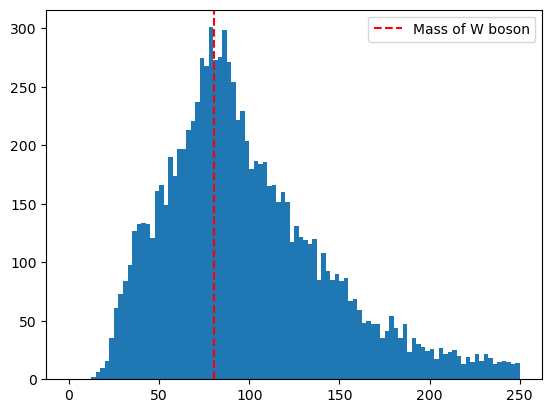

In [19]:
#DiJet Particle Mass 
mini_cut = (n_muon == 1) & (n_jets == 4)

mincut_jet = jets_cut[mini_cut]

dijet = ak.combinations(mincut_jet, 2, fields=["j1",  "j2"])
dijet["p3"] = dijet.j1 +  dijet.j2     
mask = (dijet.j1.DeepB < threshold_1) & (dijet.j2.DeepB < threshold_1) 
dijet = dijet[mask]
dijet_mass = dijet["p3"][ak.argmax(dijet.p3.pt, axis =1, keepdims = True)].mass  
di_imass = ak.flatten(dijet_mass)
plt.hist(di_imass, bins = 100, range=(0,250))
plt.axvline(80.3, color = "red",ls="--",label="Mass of W boson")
plt.legend()

In [20]:
for i in range(len(mincut_jet)): 
    if len(mincut_jet[i]) != 4: mincut_jet[i].show()

In [21]:
#Ghost_Particle_as_Neutrino:Collin
len(mincut_jet[3])

4

In [25]:
# 8-jets and 4-combinations: Samyak
jet_cut = (jets.pt>20) & (np.abs(jets.eta) < 2.4)
jets_cut = jets[jet_cut]

n_jets = ak.num(jet_cut)
n_jets_mask = n_jets == 8
jets_cut = jets_cut[n_jets_mask]

quadrajet = ak.combinations(jets_cut, 4, fields=["j1", "j2", "j3","j4"])

#New Code

#Coding in Indices of Combinations
jet4_indices = ak.Array([list(range(len(event))) for event in jets_cut])
quad_indices = ak.combinations(jet4_indices, 4)



In [26]:


# Initialize arrays to store the results
all_quads_set1 = []
all_quads_set2 = []
i = 1 
# Loop over events to process each set of 8 jets
for event_jets in jets_cut:
    current_event_all_indices = ak.Array(list(range(len(event_jets)))) # <--- FIX: Convert to Awkward Array here

    event_quads_set1 = []
    event_quads_set2 = []

    # Use a set to keep track of processed canonical pairs of index tuples
    processed_pairs = set()

    # Generate all combinations of 4 indices for the current event
    # We specify axis=0 to ensure combinations are formed from the elements of this 1D array
    quad_indices = ak.combinations(current_event_all_indices, 4, axis=0) # <--- FIX: Add axis=0

    # Iterate through each combination of 4 indices for the current event
    for combo_indices_ak in quad_indices:
        combo_indices_list = tuple(sorted(combo_indices_ak.to_list())) # Canonical form for set1 indices
        # Calculate the remaining indices (complementary set)
        remaining_indices_list = tuple(sorted([idx for idx in range(len(event_jets)) if idx not in combo_indices_list])) 
        # Create a canonical representation of the pair of index sets (order-independent)
        canonical_pair = tuple(sorted((combo_indices_list, remaining_indices_list)))

        # If this canonical pair has already been processed, skip to avoid duplicates (e.g., (A,B) and (B,A))
        if canonical_pair in processed_pairs:
            continue

        # Add the canonical pair to the set of processed pairs
        processed_pairs.add(canonical_pair)

        # Select the actual jet objects using the indices
        jets_in_set1 = event_jets[list(combo_indices_list)]
        jets_in_set2 = event_jets[list(remaining_indices_list)]

        event_quads_set1.append(jets_in_set1)
        event_quads_set2.append(jets_in_set2)
        
    all_quads_set1.append(event_quads_set1)
    all_quads_set2.append(event_quads_set2)
    print(f"Events Done: {i}")
    i+=1

# Convert lists of lists back to Awkward Arrays
quad_set1 = ak.Array(all_quads_set1)
quad_set2 = ak.Array(all_quads_set2)

print("Quad set 1 (combinations of 4 jets):")
print(quad_set1)
print("\nQuad set 2 (combinations of the other 4 jets):")
print(quad_set2)

# Verify the number of combinations (should be C(8,4)/2 = 35 per event)
print(f"\nNumber of pairs of quadjets for the first event: {len(quad_set1[0])}")
print(f"Number of pairs of quadjets for the second event: {len(quad_set1[1])}")

Events Done: 1
Events Done: 2
Events Done: 3
Events Done: 4
Events Done: 5
Events Done: 6
Events Done: 7
Events Done: 8
Events Done: 9
Events Done: 10
Events Done: 11
Events Done: 12
Events Done: 13
Events Done: 14
Events Done: 15
Events Done: 16
Events Done: 17
Events Done: 18
Events Done: 19
Events Done: 20
Events Done: 21
Events Done: 22
Events Done: 23
Events Done: 24
Events Done: 25
Events Done: 26
Events Done: 27
Events Done: 28
Events Done: 29
Events Done: 30
Events Done: 31
Events Done: 32
Events Done: 33
Events Done: 34
Events Done: 35
Events Done: 36
Events Done: 37
Events Done: 38
Events Done: 39
Events Done: 40
Events Done: 41
Events Done: 42
Events Done: 43
Events Done: 44
Events Done: 45
Events Done: 46
Events Done: 47
Events Done: 48
Events Done: 49
Events Done: 50
Events Done: 51
Events Done: 52
Events Done: 53
Events Done: 54
Events Done: 55
Events Done: 56
Events Done: 57
Events Done: 58
Events Done: 59
Events Done: 60
Events Done: 61
Events Done: 62
Events Done: 63
E

In [27]:
print("Done")

Done


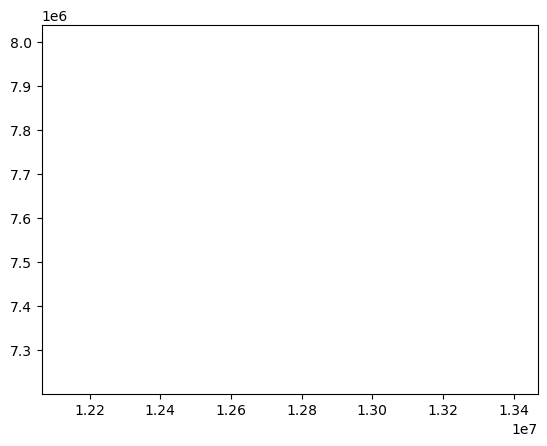

In [46]:
plt.plot(ak.sum(quad_set1.mass), ak.sum(quad_set2.mass))

In [57]:
quad_set1_mass = quad_set1.mass.tolist()

ValueError: x and y must have same first dimension, but have shapes (336562, 4) and (828805,)

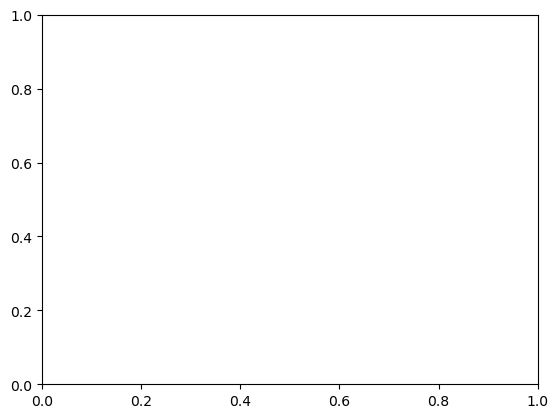

In [66]:
plt.plot(ak.flatten(quad_set1_mass),ak.ravel(quad_set2_mass))

In [59]:
quad_set2_mass = quad_set2.mass.tolist()

In [69]:
quad_set2[0].mass

<Array [[5.02, 4.66], [7.23, ...], ..., [11.9, 3.66]] type='15 * var * float64'>

In [70]:
quad_set1[0].mass

<Array [[11.9, 3.66, 7.73, 7.23], ..., [7.73, ...]] type='15 * var * float64'>